In [672]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [673]:
df = pd.read_excel('InlandEmpirePredict1.xlsx')


In [674]:
df['Period'] = pd.to_datetime(df['Period'], format='%b %Y')
df = df.sort_values('Period')


In [675]:
df['RevPAR'] = df['RevPAR'].astype(str).str.replace('$', '').astype(float)

In [676]:
df.set_index('Period', inplace=True)

In [677]:
#LSTM with TenYear
scaler = MinMaxScaler(feature_range=(0, 1))
df[['RevPAR', 'TenYear']] = scaler.fit_transform(df[['RevPAR', 'TenYear']])

In [678]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), :]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [679]:
time_step = 10
X, Y = create_dataset(df.values, time_step)

In [680]:
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

In [681]:
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

In [682]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

In [683]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [684]:
model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_88 (LSTM)              (None, 10, 50)            10600     
                                                                 
 lstm_89 (LSTM)              (None, 50)                20200     
                                                                 
 dense_54 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30851 (120.51 KB)
Trainable params: 30851 (120.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [685]:
model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/10
5/5 [==============================] - 6s 262ms/step - loss: 0.1943 - val_loss: 0.0050
Epoch 2/10
5/5 [==============================] - 0s 25ms/step - loss: 0.0238 - val_loss: 0.0371
Epoch 3/10
5/5 [==============================] - 0s 26ms/step - loss: 0.0348 - val_loss: 0.0189
Epoch 4/10
5/5 [==============================] - 0s 24ms/step - loss: 0.0090 - val_loss: 0.0061
Epoch 5/10
5/5 [==============================] - 0s 26ms/step - loss: 0.0137 - val_loss: 0.0054
Epoch 6/10
5/5 [==============================] - 0s 29ms/step - loss: 0.0097 - val_loss: 0.0066
Epoch 7/10
5/5 [==============================] - 0s 29ms/step - loss: 0.0054 - val_loss: 0.0074
Epoch 8/10
5/5 [==============================] - 0s 36ms/step - loss: 0.0061 - val_loss: 0.0064
Epoch 9/10
5/5 [==============================] - 0s 28ms/step - loss: 0.0044 - val_loss: 0.0068
Epoch 10/10
5/5 [==============================] - 0s 30ms/step - loss: 0.0049 - val_loss: 0.0074


In [686]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

5/5 [==============================] - 0s 5ms/step


In [687]:
train_predict_full = np.zeros((train_predict.shape[0], X.shape[2]))
train_predict_full[:, 0] = train_predict[:, 0]
test_predict_full = np.zeros((test_predict.shape[0], X.shape[2]))
test_predict_full[:, 0] = test_predict[:, 0]

In [688]:
train_predict = scaler.inverse_transform(train_predict_full)[:, 0]
test_predict = scaler.inverse_transform(test_predict_full)[:, 0]

In [689]:
Y_train_actual = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], X.shape[2] - 1))), axis=1))[:, 0]
Y_test_actual = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], X.shape[2] - 1))), axis=1))[:, 0]

In [690]:
train_mse = mean_squared_error(Y_train_actual, train_predict)
test_mse = mean_squared_error(Y_test_actual, test_predict)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_mae = mean_absolute_error(Y_train_actual, train_predict)
test_mae = mean_absolute_error(Y_test_actual, test_predict)

In [691]:
print("Train MSE: ", train_mse)
print("Test MSE: ", test_mse)
print("Train RMSE: ", train_rmse)
print("Test RMSE: ", test_rmse)
print("Train MAE: ", train_mae)
print("Test MAE: ", test_mae)


Train MSE:  68.5773573066221
Test MSE:  111.93367136903103
Train RMSE:  8.281144685767911
Test RMSE:  10.579871046899912
Train MAE:  6.608125389084811
Test MAE:  8.134864300285324


1/1 [==============================] - 0s 34ms/step


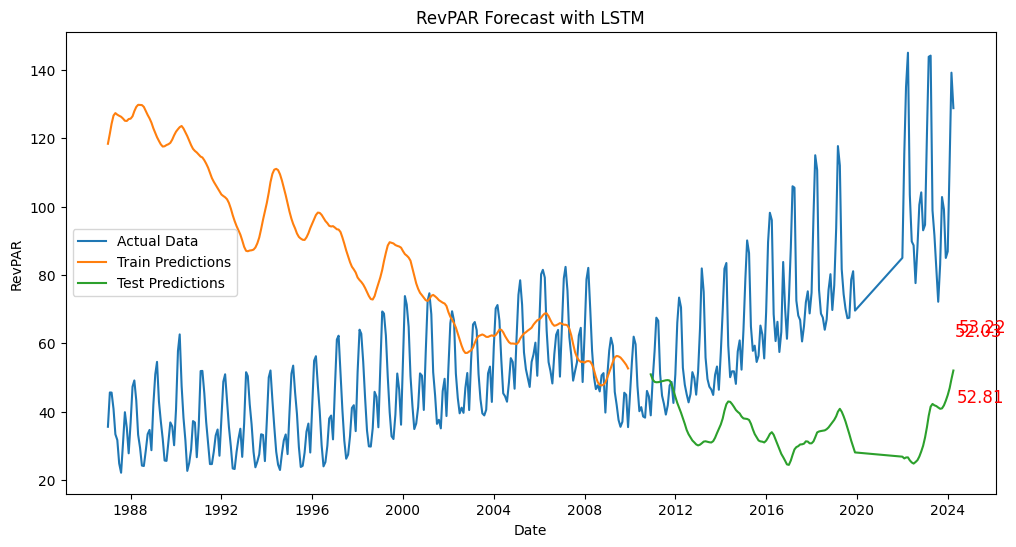

In [692]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, scaler.inverse_transform(df[['RevPAR', 'TenYear']])[:, 0], label='Actual Data')
plt.plot(df.index[:len(train_predict)], train_predict, label='Train Predictions')
plt.plot(df.index[len(train_predict) + time_step + 1:], test_predict, label='Test Predictions')
plt.xlabel('Date')
plt.ylabel('RevPAR')
plt.title('RevPAR Forecast with LSTM')
plt.legend()


X_input = X[-1].reshape((1, time_step, X.shape[2]))
forecast = []
for i in range(3):
    next_pred = model.predict(X_input)
    forecast.append(next_pred[0, 0])
    next_pred_full = np.zeros((1, X.shape[2]))
    next_pred_full[0, 0] = next_pred[0, 0]
    X_input = np.append(X_input[:, 1:, :], next_pred_full.reshape(1, 1, X.shape[2]), axis=1)


forecast_full = np.zeros((len(forecast), X.shape[2]))
forecast_full[:, 0] = forecast
forecast = scaler.inverse_transform(forecast_full)[:, 0]


last_date = df.index[-1]
future_dates = [last_date + pd.DateOffset(months=i) for i in range(1, 4)]


for i, val in enumerate(forecast):
    offset = 10 if i % 2 == 0 else -10
    plt.text(future_dates[i], val + offset, str(round(val, 2)), color='red', fontsize=12)

plt.show()

In [693]:
print("Forecast for the next 3 months:")
for i, val in enumerate(forecast, 1):
    print(f"Month {i}: ${val:.2f}")

Forecast for the next 3 months:
Month 1: $52.03
Month 2: $52.81
Month 3: $53.22


In [694]:
#LSTM without TenYear
df = pd.read_excel('InlandEmpirePredict1.xlsx')

In [695]:
df['Period'] = pd.to_datetime(df['Period'], format='%b %Y')
df = df.sort_values('Period')

In [696]:
df['RevPAR'] = df['RevPAR'].astype(str).str.replace('$', '').astype(float)

In [697]:
df.set_index('Period', inplace=True)

In [698]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['RevPAR'] = scaler.fit_transform(df[['RevPAR']])

In [699]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [700]:
time_step = 10
X, Y = create_dataset(df[['RevPAR']].values, time_step)

In [701]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [702]:
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

In [703]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

In [704]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [705]:
model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_90 (LSTM)              (None, 10, 50)            10400     
                                                                 
 lstm_91 (LSTM)              (None, 50)                20200     
                                                                 
 dense_55 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [706]:
model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/10
5/5 [==============================] - 6s 455ms/step - loss: 0.0353 - val_loss: 0.0739
Epoch 2/10
5/5 [==============================] - 0s 25ms/step - loss: 0.0131 - val_loss: 0.0259
Epoch 3/10
5/5 [==============================] - 0s 27ms/step - loss: 0.0148 - val_loss: 0.0361
Epoch 4/10
5/5 [==============================] - 0s 26ms/step - loss: 0.0111 - val_loss: 0.0525
Epoch 5/10
5/5 [==============================] - 0s 24ms/step - loss: 0.0117 - val_loss: 0.0545
Epoch 6/10
5/5 [==============================] - 0s 30ms/step - loss: 0.0115 - val_loss: 0.0457
Epoch 7/10
5/5 [==============================] - 0s 25ms/step - loss: 0.0110 - val_loss: 0.0381
Epoch 8/10
5/5 [==============================] - 0s 24ms/step - loss: 0.0109 - val_loss: 0.0388
Epoch 9/10
5/5 [==============================] - 0s 33ms/step - loss: 0.0109 - val_loss: 0.0418
Epoch 10/10
5/5 [==============================] - 0s 28ms/step - loss: 0.0108 - val_loss: 0.0399


In [707]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

5/5 [==============================] - 0s 6ms/step


In [708]:
train_predict_full = np.zeros((train_predict.shape[0], 1))
train_predict_full[:, 0] = train_predict[:, 0]
test_predict_full = np.zeros((test_predict.shape[0], 1))
test_predict_full[:, 0] = test_predict[:, 0]

In [709]:
train_predict = scaler.inverse_transform(train_predict_full)[:, 0]
test_predict = scaler.inverse_transform(test_predict_full)[:, 0]

In [710]:
Y_train_actual = scaler.inverse_transform(Y_train.reshape(-1, 1))[:, 0]
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))[:, 0]


In [711]:
train_mse = mean_squared_error(Y_train_actual, train_predict)
test_mse = mean_squared_error(Y_test_actual, test_predict)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_mae = mean_absolute_error(Y_train_actual, train_predict)
test_mae = mean_absolute_error(Y_test_actual, test_predict)

In [712]:
print("Train MSE: ", train_mse)
print("Test MSE: ", test_mse)
print("Train RMSE: ", train_rmse)
print("Test RMSE: ", test_rmse)
print("Train MAE: ", train_mae)
print("Test MAE: ", test_mae)


Train MSE:  162.23889737319928
Test MSE:  602.2749662613566
Train RMSE:  12.737303379177215
Test RMSE:  24.541291047158797
Train MAE:  10.53319637997211
Test MAE:  16.63618742695908


1/1 [==============================] - 0s 26ms/step


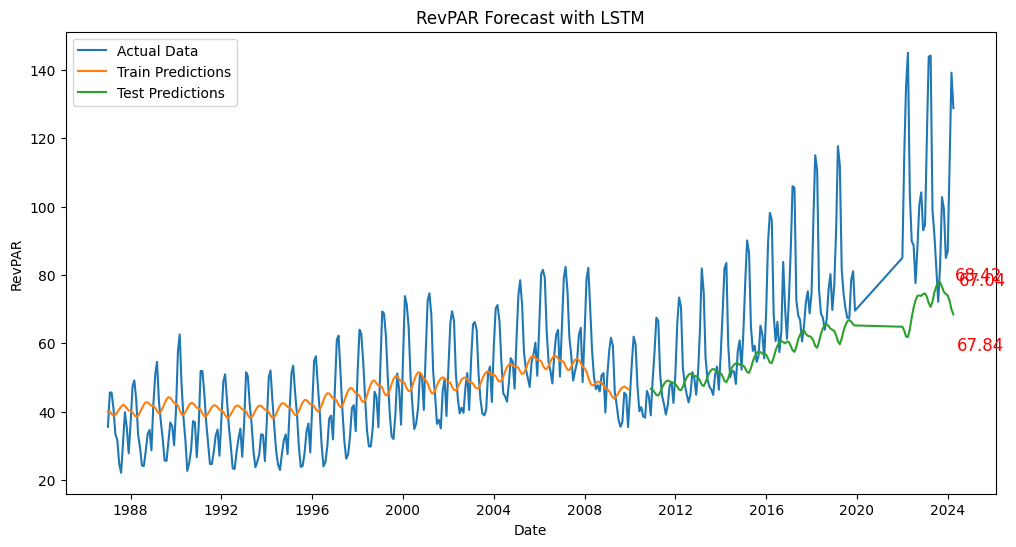

In [713]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, scaler.inverse_transform(df[['RevPAR']])[:, 0], label='Actual Data')
plt.plot(df.index[:len(train_predict)], train_predict, label='Train Predictions')
plt.plot(df.index[len(train_predict) + time_step + 1:], test_predict, label='Test Predictions')
plt.xlabel('Date')
plt.ylabel('RevPAR')
plt.title('RevPAR Forecast with LSTM')
plt.legend()

X_input = X[-1].reshape((1, time_step, 1))
forecast = []
for i in range(3):
    next_pred = model.predict(X_input)
    forecast.append(next_pred[0, 0])
    X_input = np.append(X_input[:, 1:, :], next_pred.reshape(1, 1, 1), axis=1)

forecast_full = np.zeros((len(forecast), 1))
forecast_full[:, 0] = forecast
forecast = scaler.inverse_transform(forecast_full)[:, 0]

last_date = df.index[-1]
future_dates = [last_date + pd.DateOffset(months=i) for i in range(1, 4)]

for i, val in enumerate(forecast):
    offset = 10 if i % 2 == 0 else -10
    plt.text(future_dates[i], val + offset, str(round(val, 2)), color='red', fontsize=12)

plt.show()

In [714]:
print("Forecast for the next 3 months:")
for i, val in enumerate(forecast, 1):
    print(f"Month {i}: ${val:.2f}")

Forecast for the next 3 months:
Month 1: $68.42
Month 2: $67.84
Month 3: $67.04
